# Use new algorithm to run the batch processing

## Create the calculator

All the data processing is done by the `Calculator`. The input data and output data are stored in its attributes.

In [3]:
from tomography.utils import Calculator

calculator = Calculator()

## Load the experiment Data

In this example, we load the data from a database. You can also use your data source as long as there is an `DataArray` of the exposure images.

In [4]:
from databroker import catalog

list(catalog)

['test_data_in_database',
 'analysis',
 'bt_safN_306132',
 'pdf',
 'saf_307381',
 'xpd']

In [5]:
db = catalog["xpd"]

In [6]:
UID = '257b5581-ca78-4309-9c50-b4d65d80152a'
run = db[UID]
run

BlueskyRun
  uid='257b5581-ca78-4309-9c50-b4d65d80152a'
  exit_status='success'
  2021-03-19 22:48:19.253 -- 2021-03-19 23:13:41.753
  Streams:
    * primary


In [7]:
data = run.primary.to_dask()
data

<xarray.Dataset>
Dimensions:              (dim_0: 1, dim_1: 3888, dim_2: 3072, time: 1001)
Coordinates:
  * time                 (time) float64 1.616e+09 1.616e+09 ... 1.616e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image         (time, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mPhi                 (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mPhi_user_setpoint   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

Here, we give the data to the attribute.

In [8]:
calculator.frames_arr = data["dexela_image"][::10]
calculator.frames_arr

,Array,Chunk
Bytes,8.99 GiB,91.12 MiB
Shape,"(101, 1, 3888, 3072)","(1, 1, 3888, 3072)"
Count,3104 Tasks,101 Chunks
Type,float64,numpy.ndarray


We also need the metadata of the grid scan, especially the `shape` of the grid. If not provided, the calculation can still be done but the coordinates of the grain map is unknown.

In [9]:
# show the metadata
metadata = dict(run.metadata["start"])
# Because I terminate the data. I nedd to update the metadata.
metadata["shape"] = [101]
metadata["extents"] = ([-0.5, 0.499],)
calculator.metadata = metadata
calculator.metadata

{'time': 1616208499.2537348,
 'uid': '257b5581-ca78-4309-9c50-b4d65d80152a',
 'versions': {'ophyd': '1.3.3', 'bluesky': '1.6.7'},
 'scan_id': 45,
 'proposal_id': '307690',
 'plan_type': 'generator',
 'plan_name': 'rel_grid_scan',
 'detectors': ['dexela'],
 'motors': ['mPhi'],
 'num_points': 1001,
 'num_intervals': 1000,
 'plan_args': {'detectors': ["XPDDDexelaDetector(prefix='XF:28IDD-ES:2{Det:DEX}', name='dexela', read_attrs=['stats1', 'stats1.total', 'tiff'], configuration_attrs=['cam', 'cam.acquire_period', 'cam.acquire_time', 'cam.image_mode', 'cam.trigger_mode', 'stats1', 'stats1.configuration_names', 'stats1.port_name', 'stats1.asyn_pipeline_config', 'stats1.blocking_callbacks', 'stats1.enable', 'stats1.nd_array_port', 'stats1.plugin_type', 'stats1.bgd_width', 'stats1.centroid_threshold', 'stats1.compute_centroid', 'stats1.compute_histogram', 'stats1.compute_profiles', 'stats1.compute_statistics', 'stats1.hist_max', 'stats1.hist_min', 'stats1.hist_size', 'stats1.profile_cursor', 

We can also apply the geometry of the experiment to let the calculator calculate the Q value of the peaks. This is optional.

In [33]:
from  pyFAI.azimuthalIntegrator import AzimuthalIntegrator

calculator.ai = AzimuthalIntegrator(dist=200, wavelength=0.186, detector="dexela2923", poni1=1536, poni2=1944)

## Process the data

The simplest way to use the calculator is to use the `auto_process`. It takes three necessary parameters. You will find the meaning of them in the docs.

In [38]:
help(calculator.auto_process)

Help on method auto_process in module tomography.utils:

auto_process(num_wins: int, hw_wins: int, diameter: int, index_filter: slice = None, *args, **kwargs) -> None method of tomography.utils.Calculator instance
    Automatically process the data in the standard protocol.
    
    Parameters
    ----------
    num_wins : int
        The number of windows.
    hw_wins : int
        The half width of the windows in pixels.
    diameter : int
        The diameter of the kernel to use in peak finding in pixels. It must be an odd integer.
    index_filter : slice
        The index slice of the data to use in the calculation of the dark and light image.
    args :
        The position arguments of the peak finding function `trackpy.locate`.
    kwargs :
        The keyword arguments of the peak finding function `trackpy.locate`.
    
    Returns
    -------
    None. The calculation results are saved in attributes.



Here we process the data. The new algorithm is a two-run-through algorithm so there are two status bars. First one show the status of the calculation of light and dark image and the second one shows the status of the calculation of the crystal maps.

In [11]:
calculator.auto_process(num_wins=4, hw_wins=25, diameter=41)

100%|██████████| 101/101 [00:28<00:00,  3.53it/s]


## Visualize the data

All the final, intermediate and raw data can be visualized. The methods to visualize them starts with "show". Here, we show two examples.

Here, we show the windows on the dark subtracted light image.

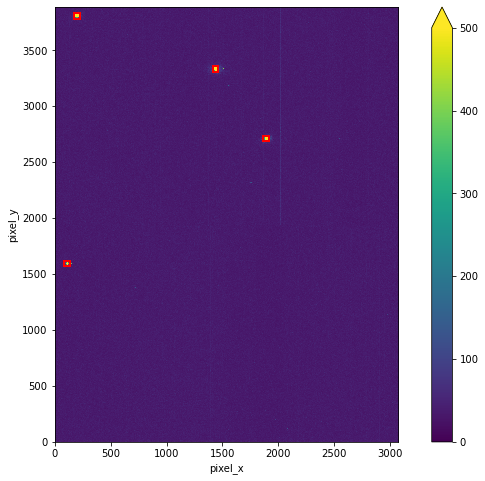

In [39]:
calculator.show_windows(vmax=500, size=8);

Then, we show the final rocking curves plot, where are the one dimensional crystal maps.

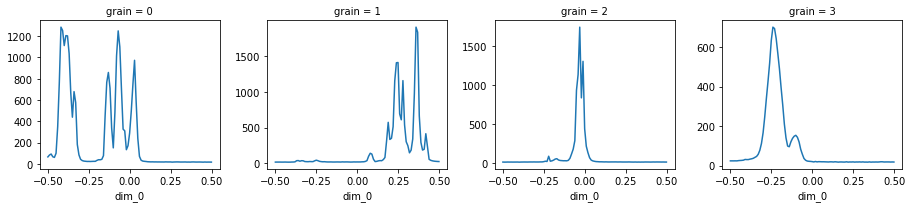

In [23]:
calculator.show_intensity();

## Save the data

The data can be converted to `DataSet` and you can save it in multiple formats.

In [31]:
ds = calculator.to_dataset()
ds

<xarray.Dataset>
Dimensions:    (dim_0: 101, grain: 4, pixel_x: 3072, pixel_y: 3888)
Coordinates:
  * grain      (grain) int64 3 2 1 0
  * dim_0      (dim_0) float64 -0.5 -0.49 -0.48 -0.47 ... 0.479 0.489 0.499
Dimensions without coordinates: pixel_x, pixel_y
Data variables:
    dark       (pixel_y, pixel_x) float64 300.0 303.0 300.0 ... 297.0 311.0
    light      (pixel_y, pixel_x) float64 339.0 339.0 336.0 ... 332.0 341.0
    intensity  (grain, dim_0) float64 65.69 83.61 92.62 ... 17.92 18.29 17.96
    y          (grain) int64 3809 3334 2712 1595
    dy         (grain) int64 25 25 25 25
    x          (grain) int64 200 1437 1890 109
    dx         (grain) int64 25 25 25 25
    Q          (grain) float64 4.38e-08 4.38e-08 4.38e-08 4.38e-08
Attributes: (12/22)
    time:                 1616208499.2537348
    uid:                  257b5581-ca78-4309-9c50-b4d65d80152a
    versions:             {'ophyd': '1.3.3', 'bluesky': '1.6.7'}
    scan_id:              45
    proposal_id:          307690
    plan_type:            generator
    ...                   ...
    plan_pattern:         outer_product
    plan_pattern_args:    {'args': ["EpicsMotor(prefix='XF:28IDD-ES:2{Stg:Sta...
    plan_pattern_module:  bluesky.plan_patterns
    task:                 a single point rocking curve
    sample:               PARADIM-2
    beam:                 slit

Here, we save it in `NetCDF` format. Before it is saved, the `attrs` need to be cleaned.

In [41]:
ds.attrs = {}
ds.to_netcdf("data/example.nc")

## Load the dataset and visualize it

The data can be loaded and visualized again after the data processing session is over.

In [42]:
import xarray as xr

ds = xr.load_dataset("data/example.nc")

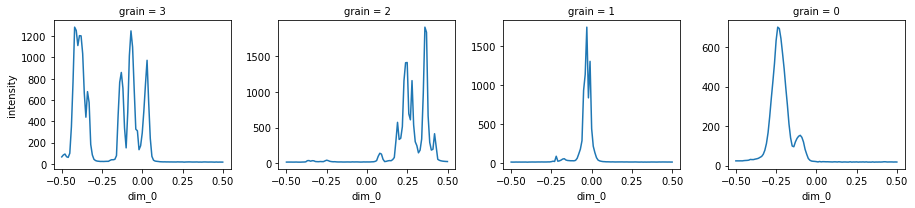

In [43]:
calculator.auto_visualize(ds);